In [422]:
import numpy as np
import jax.numpy as jnp
from scipy.stats import multivariate_normal as mvn
import matplotlib.pylab as plt
from jax import jacfwd

In [423]:
# def measurement(v1, v2):
#     rg = jnp.linalg.norm(v1 - v2)
#     br = (v2[1] - v1[1]) / rg + (v2[0] - v1[0]) / rg
#     return jnp.array([rg, br])

def measurement(v1, v2):
    return v2 - v1 

# def measurement(v1, v2):
#     return v2 ** 2 - v1 

print('test measurement: ', measurement(np.array([0.,0.]), np.array([1.,2.])))

test measurement:  [1. 2.]


In [424]:
measurement_jac_v1 = jacfwd(measurement, argnums=0)
measurement_jac_v2 = jacfwd(measurement, argnums=1)
print('test measurement jacobian:')
print(measurement_jac_v1(np.array([0.,0.]), np.array([1.,2.])))
print(measurement_jac_v2(np.array([0.,0.]), np.array([1.,2.])))

test measurement jacobian:
[[-1. -0.]
 [-0. -1.]]
[[1. 0.]
 [0. 1.]]


In [425]:
nodes_gt = np.array([
    [0., 0.],
    [1., 0.],
    [2., 0.],
    [1., 1.],
    [2., 1.],
])

In [426]:
import time
np.random.seed(int(time.time()*1000) % 1000)
noise = mvn.rvs(mean=np.zeros(2), cov=np.diag([0.2, 0.2]), size=5)
noise = np.clip(noise, a_min=-0.3, a_max=0.3)
nodes_ns = nodes_gt + noise

In [427]:
edges = np.array([
    [0, 1],
    [0, 3],
    [1, 3],
    [1, 2],
    [2, 4]
], dtype=int)

In [428]:
def config_figure(title=None):
    fig, ax = plt.subplots(1, 1, figsize=(8., 6.))
    ax.set_aspect('equal')
    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(-0.5, 1.5)
    if title is not None:
        ax.set_title(title, fontsize=15)
    return fig, ax

In [429]:
def plot_graph(nodes, edges, title=None):
    fig, ax = config_figure(title)
    
    for edge in edges:
        n1 = nodes[edge[0]]
        n2 = nodes[edge[1]]
        ax.plot([n1[0], n2[0]], [n1[1], n2[1]], color='C1', linewidth=5)
    for i in range(nodes.shape[0]):
        node = nodes[i]
        ax.plot(node[0], node[1], c='C0', linestyle='', marker='o', markersize=20)
        ax.text(node[0]+0.05, node[1]-0.12, 'node{}'.format(i), fontsize=12, fontweight='heavy', color='C0')
    
    plt.show()

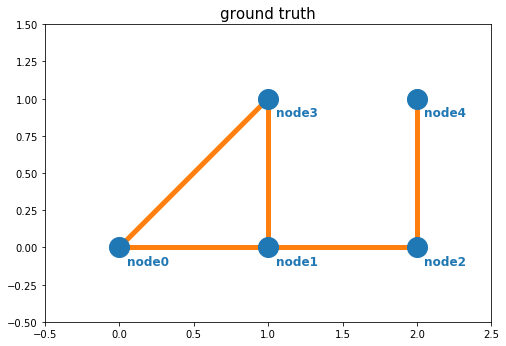

In [430]:
plot_graph(nodes_gt, edges, 'ground truth')

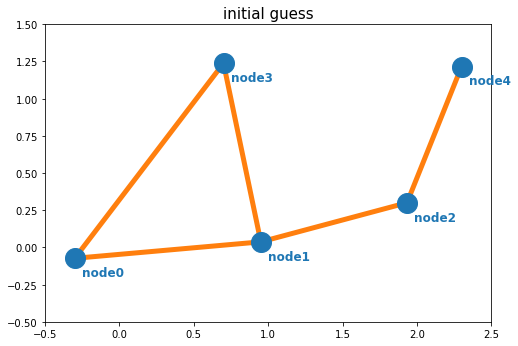

In [431]:
plot_graph(nodes_ns, edges, 'initial guess')

In [432]:
obsv_gt = np.array([
    measurement(nodes_gt[edge[0]], nodes_gt[edge[1]])
    for edge in edges
])
obsv_gt

array([[1., 0.],
       [1., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [433]:
noise = mvn.rvs(mean=np.zeros(2), cov=np.diag([0.001, 0.001]), size=5)
noise = np.clip(noise, a_min=-0.05, a_max=0.05)
obsv_ns = obsv_gt + noise
obsv_ns[:,1] = np.clip(obsv_ns[:,1], a_min=-1., a_max=1.)
obsv_ns

array([[ 0.95520676,  0.00298147],
       [ 0.97544572,  1.        ],
       [-0.03442972,  1.        ],
       [ 0.95364145,  0.01276102],
       [-0.05      ,  0.98705403]])

In [434]:
def binary_factor(v1, v2, obsv):
    sim_obsv = np.array(measurement(v1, v2))
    diff = sim_obsv - obsv
    return (diff[0]**2 + diff[1]**2) #/ 0.01

binary_factor(nodes_gt[0], nodes_gt[1], obsv_ns[0])

0.002015323702320943

In [435]:
def objective(nodes, edges, obsv_list):
    obj = 0.
    for i in range(edges.shape[0]):
        ed = edges[i]
        v1 = nodes[ed[0]]
        v2 = nodes[ed[1]]
        obsv = obsv_list[i]
        obj += binary_factor(v1, v2, obsv) / 2
    return obj
    
objective(nodes_gt, edges, obsv_ns)

0.004391599100091575

In [436]:
def objective_jac(nodes, edges, obsv_list):
    jac = np.zeros_like(nodes)
    for i in range(edges.shape[0]):
        ed = edges[i]
        v1 = nodes[ed[0]]
        v2 = nodes[ed[1]]
        obsv = obsv_list[i]
        diff = measurement(v1, v2) - obsv
        jac_v1 = measurement_jac_v1(v1, v2)
        jac_v2 = measurement_jac_v2(v1, v2) 
        jac[ed[0]] += jac_v1 @ diff
        jac[ed[1]] += jac_v2 @ diff
    return jac

In [437]:
objective_jac(nodes_gt, edges, obsv_ns)

array([[-0.06934752,  0.00298147],
       [-0.03599502,  0.00977955],
       [-0.00364145, -0.02570699],
       [ 0.05898399,  0.        ],
       [ 0.05      ,  0.01294597]])

In [438]:
def fg_armijo(x, p, f, df):
    c = 1e-04
    a = 1.0
    rho = 0.5
    for i in range(10):
        df_sum = 0.
        df_k = df(x)
        for j in range(p.shape[0]):
            df_sum += p[j][0]*df_k[j][0] + p[j][1]*df_k[j][1]
        gap = f(x + a*p) - f(x) - c*a*df_sum
        #print('armijo {} gap: {}'.format(i, gap))
        if gap < 0.:
            return a
        else:
            a *= rho
    return 0.0

In [439]:
nodes_p = objective_jac(nodes_gt, edges, obsv_ns)
step_len = fg_armijo(nodes_gt, -nodes_p, 
                     lambda nodes: objective(nodes, edges, obsv_ns), 
                     lambda nodes: objective_jac(nodes, edges, obsv_ns))

In [440]:
def fg_gradient_descent(nodes, edges, obsv_list):
    nodes_k = nodes.copy()
    for i in range(50):
        obj_k = objective(nodes_k, edges, obsv_list)
        nodes_p = objective_jac(nodes_k, edges, obsv_list)
        nodes_p_norm = np.linalg.norm(nodes_p)
        
#         if(nodes_p_norm < 1e-06):
#             print('converged.')
#             break
        
        step_len = fg_armijo(nodes_k, -nodes_p, 
                             lambda nodes: objective(nodes, edges, obsv_list), 
                             lambda nodes: objective_jac(nodes, edges, obsv_list))
        
        nodes_k -= nodes_p * step_len
        obj_knew = objective(nodes_k, edges, obsv_list)
        
        drop = obj_k - obj_knew
        print('iteration {}: {}, {}'.format(i, obj_k, drop))
        if drop < 1e-04:
            print('converged.')
            break
        
    return nodes_k

iteration 0: 0.26270664918712294, 0.08988271458002589
iteration 1: 0.17282393460709705, 0.015311143526401283
iteration 2: 0.15751279108069577, 0.1377007509410403
iteration 3: 0.019812040139655457, 0.011492412311362396
iteration 4: 0.00831962782829306, 0.0024166570526011595
iteration 5: 0.005902970775691901, 0.000808816949596728
iteration 6: 0.005094153826095173, 7.500680367426241e-05
converged.


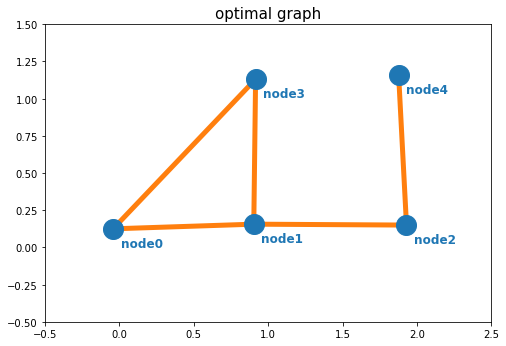

In [441]:
nodes_opt = fg_gradient_descent(nodes_ns, edges, obsv_ns)
plot_graph(nodes_opt, edges, 'optimal graph')

In [442]:
def linearized_objective_jac(increments, nodes, edges, obsv_list):
    jac = np.zeros_like(nodes)
    for i in range(edges.shape[0]):
        ed = edges[i]
        v1 = nodes[ed[0]]
        v2 = nodes[ed[1]]
        icrmt1 = increments[ed[0]]
        icrmt2 = increments[ed[1]]
        obsv = obsv_list[i]
        
        jac_v1 = measurement_jac_v1(v1, v2)
        jac_v2 = measurement_jac_v2(v1, v2)
        c = measurement(v1, v2) - obsv
        diff1 = jac_v1 @ icrmt1 + jac_v2 @ icrmt2 + c
        diff2 = jac_v1 @ icrmt1 + jac_v2 @ icrmt2 + c
        
        jac[ed[0]] += jac_v1 @ diff1
        jac[ed[1]] += jac_v2 @ diff2
        
    return jac

In [443]:
increments_test = np.ones_like(nodes_gt) * 0.0
print(objective_jac(nodes_ns, edges, obsv_ns), end='\n\n')
print(linearized_objective_jac(increments_test, nodes_ns, edges, obsv_ns))

[[-0.32000181 -0.41852522]
 [ 0.48299739 -0.34283957]
 [-0.3883549   0.32144469]
 [-0.19167028  0.51135126]
 [ 0.41702957 -0.07143117]]

[[-0.32000181 -0.41852522]
 [ 0.48299739 -0.34283957]
 [-0.3883549   0.32144469]
 [-0.19167028  0.51135129]
 [ 0.41702959 -0.07143117]]


In [444]:
def linearized_objective_fullmatrix(increments, nodes, edges, obsv_list):
    J = np.zeros((obsv_list.ravel().shape[0], nodes.ravel().shape[0]))
    y = np.zeros(obsv_list.ravel().shape[0])
    
    for i in range(edges.shape[0]):
        ed = edges[i]
        v1 = nodes[ed[0]]
        v2 = nodes[ed[1]]
        icrmt1 = increments[ed[0]]
        icrmt2 = increments[ed[1]]
        obsv = obsv_list[i]
        
        diff = measurement(v1, v2) - obsv
        y[i*2 : i*2+2] = diff
        
        jac_v1 = measurement_jac_v1(v1, v2)
        jac_v2 = measurement_jac_v2(v1, v2)
        J[i*2][ed[0]*2 : ed[0]*2+2] = jac_v1[:,0]
        J[i*2][ed[1]*2 : ed[1]*2+2] = jac_v2[:,0]
        J[i*2+1][ed[0]*2 : ed[0]*2+2] = jac_v1[:,1]
        J[i*2+1][ed[1]*2 : ed[1]*2+2] = jac_v2[:,1]
    
    return np.linalg.norm(J @ increments.ravel() - y) ** 2 / 2

In [445]:
increments_test = np.random.normal(size=nodes_ns.shape) * 0.01
print(linearized_objective_fullmatrix(increments_test, nodes_ns, edges, obsv_ns))
print(objective(nodes_ns+increments_test, edges, obsv_ns))

0.2509885054233831
0.27567224366665666


In [446]:
def linearized_objective_jac_fullmatrix(increments, nodes, edges, obsv_list):
    J = np.zeros((obsv_list.ravel().shape[0], nodes.ravel().shape[0]))
    y = np.zeros(obsv_list.ravel().shape[0])
    
    for i in range(edges.shape[0]):
        ed = edges[i]
        v1 = nodes[ed[0]]
        v2 = nodes[ed[1]]
        icrmt1 = increments[ed[0]]
        icrmt2 = increments[ed[1]]
        obsv = obsv_list[i]
        
        diff = measurement(v1, v2) - obsv
        y[i*2 : i*2+2] = diff
        
        jac_v1 = measurement_jac_v1(v1, v2)
        jac_v2 = measurement_jac_v2(v1, v2)
        J[i*2][ed[0]*2 : ed[0]*2+2] = jac_v1[:,0]
        J[i*2][ed[1]*2 : ed[1]*2+2] = jac_v2[:,0]
        J[i*2+1][ed[0]*2 : ed[0]*2+2] = jac_v1[:,1]
        J[i*2+1][ed[1]*2 : ed[1]*2+2] = jac_v2[:,1]
    
    return J, y, J.T @ (J @ increments.ravel() + y)

[[-0.3200018  -0.41852522]
 [ 0.48299738 -0.34283957]
 [-0.38835488  0.32144469]
 [-0.19167028  0.51135126]
 [ 0.41702957 -0.07143117]]


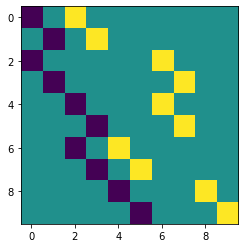

In [447]:
increments_test = np.ones_like(nodes_gt) * 0.0
J, y, obj_jac = linearized_objective_jac_fullmatrix(increments_test, nodes_ns, edges, obsv_ns)
print(obj_jac.reshape(-1,2))
plt.imshow(J)

In [448]:
def fg_gauss_newton(nodes, edges, obsv_list):
    nodes_k = nodes.copy()
    for i in range(50):
        obj_k = objective(nodes_k, edges, obsv_list)
        
        J, y, obj_jac = linearized_objective_jac_fullmatrix(np.zeros_like(nodes_k), nodes_k, edges, obsv_list)
        #nodes_p = np.linalg.inv(J.T @ J) @ (-J.T @ y)
        nodes_p = np.linalg.solve(J.T @ J, -J.T @ y) # more stable
        nodes_p = np.array(nodes_p).reshape(-1,2)
        
        nodes_p_norm = np.linalg.norm(nodes_p)
        
        step_len = fg_armijo(nodes_k, nodes_p, 
                             lambda nodes: objective(nodes, edges, obsv_list), 
                             lambda nodes: objective_jac(nodes, edges, obsv_list))
        
        nodes_k += nodes_p * step_len
        obj_knew = objective(nodes_k, edges, obsv_list)
        
        drop = obj_k - obj_knew
        print('iteration {}: {}, {}'.format(i, obj_k, drop))
        if drop < 1e-04:
            print('converged.')
            break
        
    return nodes_k

iteration 0: 0.26270664918712294, 0.26220705691270324
iteration 1: 0.000499592274419725, 2.2768245622195593e-18
converged.


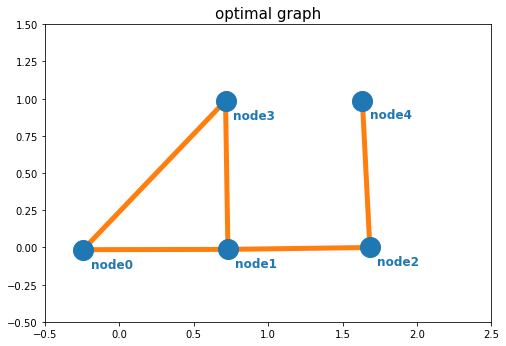

In [449]:
nodes_opt_gn = fg_gauss_newton(nodes_ns, edges, obsv_ns)
plot_graph(nodes_opt_gn, edges, 'optimal graph')

In [450]:
def back_substitute(A, b): # A is square upper-triangular
    x = np.zeros_like(b)
    for i in range(x.shape[0]):
        curr_row = x.shape[0] - i - 1
        val = b[curr_row]
        #print(val)
        for j in range(i):
            prev_col = x.shape[0] - j - 1
            val -= x[prev_col] * A[curr_row, prev_col]
            #print(j, val)
        #print(val, A[curr_row, curr_row], val / A[curr_row, curr_row])
        if A[curr_row, curr_row] == 0.:
            x[curr_row] = 0.
        else:
            x[curr_row] = val / A[curr_row, curr_row]
    return x

In [451]:
A_test = np.array([[2, -4, 6], [0, 2, -2], [0, 0, 3]], dtype=float)
b_test = np.array([8, 1, 9], dtype=float)
x_test = back_substitute(A_test, b_test)
print(x_test)

[2.  3.5 3. ]


In [452]:
def fg_gauss_newton_qr(nodes, edges, obsv_list):
    nodes_k = nodes.copy()
    for i in range(50):
        obj_k = objective(nodes_k, edges, obsv_list)
        
        J, y, _ = linearized_objective_jac_fullmatrix(np.zeros_like(nodes_k), nodes_k, edges, obsv_list)
        
        Q, R = np.linalg.qr(J, 'reduced')
        nodes_p = back_substitute(R, -Q.T@y)
        
        #nodes_p = np.linalg.inv(J.T @ J) @ (-J.T @ y)
        #nodes_p = np.linalg.solve(J.T @ J, -J.T @ y) # more stable
        nodes_p = np.array(nodes_p).reshape(-1,2)
        
        nodes_p_norm = np.linalg.norm(nodes_p)
        
        step_len = fg_armijo(nodes_k, nodes_p, 
                             lambda nodes: objective(nodes, edges, obsv_list), 
                             lambda nodes: objective_jac(nodes, edges, obsv_list))
        
        nodes_k += nodes_p * step_len
        obj_knew = objective(nodes_k, edges, obsv_list)
        
        drop = obj_k - obj_knew
        print('iteration {}: {}, {}'.format(i, obj_k, drop))
        if drop < 1e-04:
            print('converged.')
            break
        
    return nodes_k

iteration 0: 0.26270664918712294, 0.26220705691270324
iteration 1: 0.0004995922744197227, 0.0
converged.


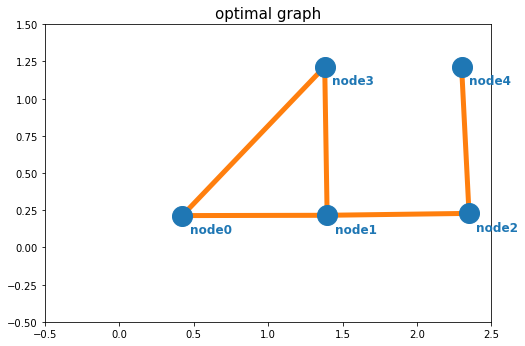

In [453]:
nodes_opt_gn = fg_gauss_newton_qr(nodes_ns, edges, obsv_ns)
plot_graph(nodes_opt_gn, edges, 'optimal graph')

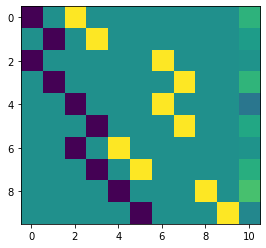

In [454]:
J, y, _ = linearized_objective_jac_fullmatrix(np.zeros_like(nodes_ns), nodes_ns, edges, obsv_ns)
plt.imshow(np.concatenate((J, y[:,np.newaxis]), axis=1))

In [511]:
def variable_elimination(J_, y_):
    J = J_.copy()
    y = y_.copy()
    full_mat = np.concatenate((J, y[:,np.newaxis]), axis=1)
    
    for i in range(J.shape[1]): # number of states
        separator = []
        rows = []
        for j in range(J.shape[0]):
            row = J[j]
            if row[i] != 0:
                rows.append(j)
                for k in range(row.shape[0]):
                    if row[k] != 0. and i != k:
                        separator.append(k)
        print('separator: ', separator, ' , rows: ', rows)
        
        separator_with_node = np.sort([i] + separator)
        print('separator with node: ', separator_with_node)
        
        a = J[rows, i]
        As = J[rows][:, separator]
        b = -y[rows]
        
        ainv = a / (a.T @ a)
        r = ainv @ As
        d = ainv @ b
        Ap = As - np.outer(a, r)
        bp = b - a * d
        
        
        y[rows] = bp

In [512]:
J, y, _ = linearized_objective_jac_fullmatrix(np.zeros_like(nodes_ns), nodes_ns, edges, obsv_ns)
variable_elimination(J, y)

separator:  [2, 6]  , rows:  [0, 2]
separator with node:  [0 2 6]
separator:  [3, 7]  , rows:  [1, 3]
separator with node:  [1 3 7]
separator:  [0, 6, 4]  , rows:  [0, 4, 6]
separator with node:  [0 2 4 6]
separator:  [1, 7, 5]  , rows:  [1, 5, 7]
separator with node:  [1 3 5 7]
separator:  [2, 8]  , rows:  [6, 8]
separator with node:  [2 4 8]
separator:  [3, 9]  , rows:  [7, 9]
separator with node:  [3 5 9]
separator:  [0, 2]  , rows:  [2, 4]
separator with node:  [0 2 6]
separator:  [1, 3]  , rows:  [3, 5]
separator with node:  [1 3 7]
separator:  [4]  , rows:  [8]
separator with node:  [4 8]
separator:  [5]  , rows:  [9]
separator with node:  [5 9]
